# Data analysis in a notebook


## Hands on Climate data analysis 


Enter xarray library!

Let us open a dataset using the xarray package.


In [20]:
import os
import xarray

CMIP_directory = '.'
CMIP_file = 'tas_day_HadGEM2-ES_historical_r1i1p1_19991201-20051130.nc'

data = xarray.open_dataset(os.path.join(CMIP_directory,CMIP_file))
print(data)

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 145, lon: 192, time: 2160)
Coordinates:
  * time       (time) datetime64[ns] 1999-12-01T12:00:00 1999-12-02T12:00:00 ...
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 -85.0 -83.75 -82.5 ...
  * lon        (lon) float64 0.0 1.875 3.75 5.625 7.5 9.375 11.25 13.12 15.0 ...
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
Attributes:
    institution:            Met Office Hadley Centre, Fitzroy Road, Exeter, D...
    institute_id:           MOHC
    experiment_id:          historical
    source:                 HadGEM2-ES (2009) atmosphere: HadGAM2 (N96L38); o...
    model_id:               HadGEM2-ES
    forcing:                GHG, SA, Oz, LU, Sl, Vl, BC, OC, (GHG = CO2, N2O,...
    parent_experiment_id:   piControl
    parent_experiment_rip: 

/usr/lib/python3/dist-packages/xarray/coding/variables.py:66: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netcdftime.datetime objects instead, reason:day is out of range for month
  return self.func(self.array[key])


### Access the data

The particular variables in xarray can be access using the handy dot syntax:


In [21]:
surface_temp = data.tas
print(surface_temp)

<xarray.DataArray 'tas' (time: 2160, lat: 145, lon: 192)>
[60134400 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1999-12-01T12:00:00 1999-12-02T12:00:00 ...
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 -85.0 -83.75 -82.5 ...
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 9.375 11.25 13.12 15.0 ...
    height   float64 ...
Attributes:
    standard_name:     air_temperature
    long_name:         Near-Surface Air Temperature
    comment:           daily-mean near-surface (usually, 2 meter) air tempera...
    units:             K
    original_name:     mo: m01s03i236
    cell_methods:      time: mean
    cell_measures:     area: areacella
    history:           2010-11-22T15:34:22Z altered by CMOR: Treated scalar d...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...


Let us now select the valus for just two years, 2000 and 2001:


In [22]:
import cftime
import numpy as np

subset = data.loc[dict(time=slice(cftime.Datetime360Day(2000,1,1), cftime.Datetime360Day(2002,1,1)))]

And let us do a time average of this two years:

In [23]:
surface_temp_mean = xarray.DataArray(np.mean(subset.tas,axis=0))

WOW! Now let us plot this 2 year average on a map:

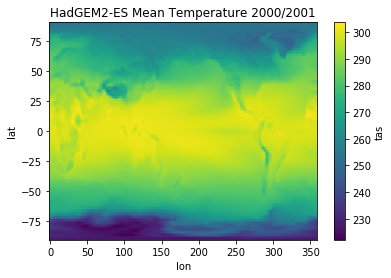

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

surface_temp_mean.plot( )
plt.title('HadGEM2-ES Mean Temperature 2000/2001')
plt.show( )

That was nice. Let us compute and plot the anomaly of this two year average over the 5 year mean data.

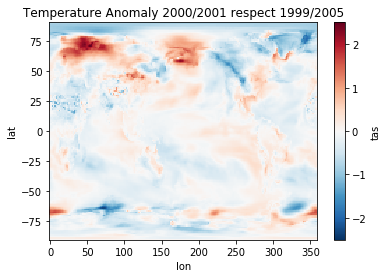

In [25]:
all_temp_mean = xarray.DataArray(np.mean(data.tas,axis=0))

anomaly = surface_temp_mean - all_temp_mean

anomaly.plot( )
plt.title('Temperature Anomaly 2000/2001 respect 1999/2005')
plt.show( )

Let us now load a measure dataset, say the CRU:

http://www.cru.uea.ac.uk/data

and compare it to our five year mean to get the BIAS.

In [26]:
OBS_directory = '.'
OBS_file = 'tmp.dat.nc'

cru = xarray.open_dataset(os.path.join(OBS_directory,OBS_file))
print(cru)

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 1404)
Coordinates:
  * lon      (lon) float32 -179.75 -179.25 -178.75 -178.25 -177.75 -177.25 ...
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 -87.75 -87.25 -86.75 ...
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 1901-03-16 ...
Data variables:
    tmp      (time, lat, lon) float32 ...
    stn      (time, lat, lon) int32 ...
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.02 Mean Temperature
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 1811131722. Data generated from:tmp.1804231108.dtb
    history:      Tue 13 Nov 2018 18:22:57 GMT : User ianharris : Program mak...
    references:   Information on the data is available at http://badc.nerc.ac...
    comment:      Access to these data is available to any registered CEDA user.
    contact:      support@ceda.ac.uk


Select the same temporal window of the HadGEM2 dataset.

In [27]:
cruwin = cru.loc[dict(time=slice("1999-12-01T00:00:00", "2005-12-01T00:00:00"))]

And now average the data over time. Note that we have also to do a unit of measure change:

In [28]:
print('CRU units : ',cruwin.tmp.units)
print('HadGEM units : ', subset.tas.units)


CRU units :  degrees Celsius
HadGEM units :  K


To convert in Kelvin, we have to add 273.15 K to the temperature in Celsius. We do this and save the data in a temporary file we will us later on for the interpolation using cdo.

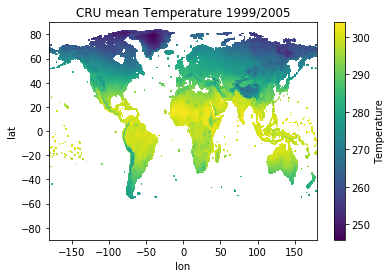

In [29]:
mean_cru = xarray.DataArray(np.mean(cruwin.tmp,axis=0)) + 273.15
mean_cru.to_netcdf('crumean.nc')

mean_cru.name = 'Temperature'
mean_cru.attrs.units = 'K'
mean_cru.plot()
plt.title('CRU mean Temperature 1999/2005')
plt.show( )

Let us resample the CRU grid to the Hadgem one.

In [30]:
import cdo

cdo = cdo.Cdo( )
gdes = "\n".join(cdo.griddes(input=os.path.join(CMIP_directory,CMIP_file)))

with open('grid.des', "w") as writer:
    writer.write(gdes)

remap_file = cdo.remapbil('grid.des', input = 'crumean.nc', output =  'ha_crumean.nc', options = '-f nc')

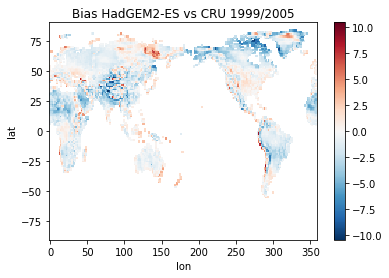

In [31]:
cru_had = xarray.open_dataset(remap_file)
bias = all_temp_mean - cru_had.tmp

bias.plot( )
plt.title('Bias HadGEM2-ES vs CRU 1999/2005')
plt.show( )

Some cleanup....

In [32]:
os.unlink('grid.des')
os.unlink('crumean.nc')
os.unlink('ha_crumean.nc')

Just one more map. we could have easiy used also gdal package!

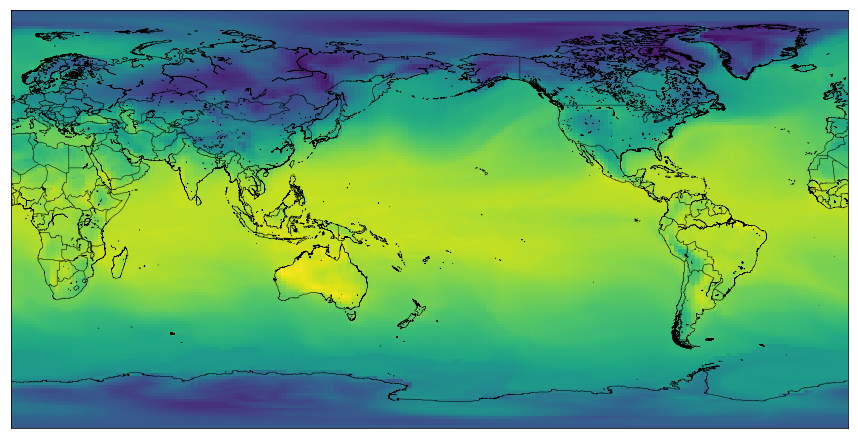

In [33]:
from osgeo import gdal
from mpl_toolkits.basemap import Basemap

ds = gdal.Open(os.path.join(CMIP_directory,CMIP_file))
bnd1 = ds.GetRasterBand(1).ReadAsArray()

fig = plt.figure(figsize=(15,15))  # a new figure window
ax = fig.add_subplot(1, 1, 1)  # specify (nrows, ncols, axnum)
nx = ds.RasterXSize # Raster xsize
ny = ds.RasterYSize # Raster ysize

gt = ds.GetGeoTransform()
proj = ds.GetProjection()

xres = gt[1]
yres = gt[5]

xmin = 0.0 
xmax = 360.0
ymin = -90.0
ymax = 90.0 

map = Basemap(projection='cyl',llcrnrlat=ymin,urcrnrlat=ymax,\
            llcrnrlon=xmin,urcrnrlon=xmax , resolution='i', ax=ax)

map.imshow(bnd1, origin='upper', ax=ax)
map.drawcountries(color='black', linewidth=0.5, ax=ax)
map.drawcoastlines(linewidth=0.5, color='black', ax=ax)


That's All Folks!